In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Data Collection

In [15]:
train_dir = 'asl_alphabet_train/asl_alphabet_train'
test_dir = 'asl_alphabet_test/asl_alphabet_test'

The code snippet processes the ASL Alphabet Dataset by iterating over each class and each image within that class.

It loads each image, preprocesses it (grayscale conversion and resizing), and stores the image data and corresponding class index in separate lists. 

Finally, it converts these lists to numpy arrays for use in model training.

In [16]:
def load_images_from_directory(directory):
    images = []
    labels = []
    classes = sorted(os.listdir(directory))
    
    for i, label in enumerate(classes):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                image = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
                image = img_to_array(image) / 255.0
                images.append(image)
                labels.append(i)
        else:
            image = load_img(class_dir, color_mode='grayscale', target_size=(64, 64))
            image = img_to_array(image) / 255.0
            images.append(image)
            labels.append(i)
    return np.array(images), np.array(labels)


In [17]:
# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

In [18]:
# Convert labels to categorical
num_classes = len(np.unique(train_labels))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

- 87000: representing the number of training images.
- 28 : representing the number of tesing images.
- 64: representing the height and width of each image.
- 1: representing the single color channel (grayscale).

In [19]:
print(f'Training data shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')

print(f'Test data shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Training data shape: (87000, 64, 64, 1)
Training labels shape: (87000, 29)
Test data shape: (28, 64, 64, 1)
Test labels shape: (28, 29)


## Visualize some samples

In [20]:
def visualize_images(images, labels, class_names, num_images):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        class_index = np.argmax(labels[i])  
        plt.title(class_names[class_index])        
        plt.axis('off')
    plt.show()

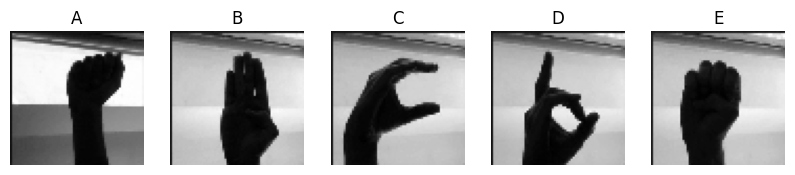

In [21]:
classes = sorted(os.listdir(train_dir))
visualize_images(test_images, test_labels, classes, num_images=5)

In [22]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

## Preprocessing

Data augmentation : is a technique used to artificially increase the size and diversity of the training dataset by creating modified versions of images in the dataset. 

This helps improve the generalization ability of the model, making it more robust to variations in input data.

- rotation_range=10: Randomly rotates images within the range of -10 to +10 degrees. This helps the model learn to recognize images from different orientations.

- width_shift_range=0.1: Randomly shifts images horizontally (left or right) by up to 10% of the image width. This simulates slight horizontal movements.

- height_shift_range=0.1: Randomly shifts images vertically (up or down) by up to 10% of the image height. This simulates slight vertical movements.

- shear_range=0.1: Applies random shearing transformations, which can be visualized as tilting the image. This helps the model recognize skewed versions of the images.

- zoom_range=0.1: Randomly zooms in or out on images by up to 10%. This makes the model more robust to variations in object size within the image.

- horizontal_flip=True: Randomly flips images horizontally. This is useful when the orientation of the objects in the images can vary (e.g., left hand vs. right hand).

- fill_mode='nearest': Determines how to fill in newly created pixels during transformations (like rotations or shifts). nearest means newly created pixels are filled with the nearest pixel value.

In [23]:
# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# datagen.fit(train_images)

## Model Selection

In [24]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,365 (2.62 MB)

 Trainable params: 686,365 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [26]:
# Train the model
history = model.fit(train_images, train_labels, batch_size=32,
                    validation_data=(val_images, val_labels),
                    epochs=20)

# Save the model
model.save('asl_alphabet_model.h5')


Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.3686 - loss: 2.1116 - val_accuracy: 0.8937 - val_loss: 0.3428
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.8351 - loss: 0.4757 - val_accuracy: 0.9785 - val_loss: 0.0876
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.9101 - loss: 0.2653 - val_accuracy: 0.9900 - val_loss: 0.0405
Epoch 4/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.9395 - loss: 0.1782 - val_accuracy: 0.9907 - val_loss: 0.0323
Epoch 5/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.9508 - loss: 0.1438 - val_accuracy: 0.9956 - val_loss: 0.0153
Epoch 6/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9590 - loss: 0.1190 - val_accuracy: 0.9922 - val_loss: 0.0252
Epoch 7/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9683 - loss: 0.0947 - val_accuracy: 0.9975 - val_loss: 0.0089
Epoch 8/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9745 -

## Evaluation

In [28]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9286 - loss: 5.4646
Test accuracy: 0.9285714030265808


## Deployment

In [29]:
import cv2

In [30]:
# Load the trained model
model = tf.keras.models.load_model('asl_alphabet_model.h5')

In [31]:
# Open the webcam
cap = cv2.VideoCapture(0)

In [32]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    normalized = resized / 255.0
    reshaped = np.reshape(normalized, (1, 64, 64, 1))

    # Make a prediction
    prediction = model.predict(reshaped)
    predicted_class = np.argmax(prediction)

    # Map the predicted class to the corresponding letter
    predicted_label = classes[predicted_class]

    # Display the predicted label on the frame
    cv2.putText(frame, predicted_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Sign Language Translation', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━